In [2]:
import pandas as pd
from ibm_watsonx_ai import Credentials, APIClient
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextGenParameters
from decouple import Config, RepositoryEnv


In [3]:
# Load the environment variables using python-decouple
# The .env file should be in the root of the project
# The .env file should NOT be committed to the repository

config = Config(RepositoryEnv(".env.paul"))

# Load the credentials
WX_API_KEY = config("WX_API_KEY")

In [4]:
credentials = Credentials(
    url = "https://us-south.ml.cloud.ibm.com",
    api_key = WX_API_KEY
)
client = APIClient(
    credentials=credentials, 
    project_id="68126b74-155e-4a70-aa2c-1781dfad87f6"
)

In [5]:
# --- Setup the Model (Granite-13b-chat-v2) ---
params = TextGenParameters(
    temperature=0.05,           # Light creativity
    max_new_tokens=300          # Enough for descriptive text
)

model = ModelInference(
    api_client=client,
    params=params,
    model_id="ibm/granite-3-8b-instruct",
)
prompt = "Hello from copenhagen!"
generated_response = model.generate(prompt)

generated_response

{'model_id': 'ibm/granite-3-8b-instruct',
 'model_version': '1.1.0',
 'created_at': '2025-05-04T18:33:06.688Z',
 'results': [{'generated_text': "\n\nI'm currently in Copenhagen, Denmark, and I'm excited to share some insights about this beautiful city. Copenhagen is the capital and largest city of Denmark, known for its rich history, stunning architecture, and vibrant culture.\n\n1. **Historical Landmarks**: Copenhagen boasts a wealth of historical landmarks. The iconic Little Mermaid statue, inspired by Hans Christian Andersen's fairy tale, is a must-visit. The Amalienborg Palace, home to the Danish royal family, is another popular attraction. Don't miss the Rosenborg Castle, which houses the Danish crown jewels and royal artifacts.\n\n2. **Museums**: Copenhagen is a hub for art and culture. The National Museum of Denmark offers a comprehensive overview of Danish history, while the Louisiana Museum of Modern Art showcases an impressive collection of modern and contemporary art. The De

In [6]:
def create_prompt(sign_name: str) -> str:
    return (
        f"You are an American Sign Language (ASL) teacher.\n\n"
        f"Please clearly explain how to perform the ASL sign on a beginner level for '{sign_name}'. "
        f"Use simple language and full sentences. Do not assume any prior knowledge about ASL.\n\n"
    )


In [7]:
# --- Generate ASL Description ---
def generate_asl_description(sign_name: str) -> str:
    prompt = create_prompt(sign_name)
    
    response = model.generate(prompt=prompt)
    generated_text = response['results'][0]['generated_text']
    
    return generated_text

In [7]:
# --- Example Usage ---
if __name__ == "__main__":
    sign_to_explain = input("📝 Enter the ASL sign you want explained: ")

    try:
        description = generate_asl_description(sign_to_explain)
        print("\n✅ Generated ASL Description:\n")
        print(description)
    except Exception as e:
        print(f"❌ Error during generation: {e}")


✅ Generated ASL Description:


To sign 'piano' in American Sign Language (ASL), follow these steps:

1. Start with your dominant hand open and facing up, palm facing you.
2. Bring your hand down to your thigh or knee area, keeping your fingers together and your thumb extended out to the side.
3. Touch the tip of your index finger to the tip of your thumb, forming a small circle.
4. While maintaining the circle with your index finger and thumb, move your hand up and down in a small, repetitive motion, as if you were pressing the keys of a piano.

Remember, ASL is a visual language, so it's essential to use facial expressions and movements to convey the meaning accurately. In this case, you can use a neutral or slightly curious facial expression to signify asking about or identifying the instrument.

Practice this sign regularly to improve your proficiency in ASL.


Judge

In [8]:
# Separate model instance for evaluation (judge)
judge_model = ModelInference(
    api_client=client,
    params=params, 
    model_id="meta-llama/llama-3-3-70b-instruct",
)


In [9]:
def create_judge_prompt(sign_name: str, description: str) -> str:
    return f"""You are evaluating the quality of a generated ASL (American Sign Language) sign description based on 3 criteria.
The criteria are:
1. Faithfulness: Are the claims in the answer factually consistent with known ASL practices (no hallucinations)?
2. Answer Relevance: Does the description directly describe the sign requested?
3. Context Relevance: Does the answer exclusively contain information that is needed to describe the sign?

Use the following scale:
- 1 = fully meets the criterion
- 0.5 = partially meets the criterion
- 0 = does not meet the criterion

Think carefully for each criterion.

ASL Sign Request:
"{sign_name}"

Generated Description:
"{description}"

Respond as a JSON object, exactly like this (no extra text or comments):

{{
  "faithfulness": <0, 0.5, or 1>,
  "answer_relevance": <0, 0.5, or 1>,
  "context_relevance": <0, 0.5, or 1>
}}"""


In [ ]:
def evaluate_description(sign_name: str, description: str) -> dict:
    import json, re

    judge_prompt = create_judge_prompt(sign_name, description)
    response = judge_model.generate(prompt=judge_prompt)
    judged_text = response['results'][0]['generated_text']

    # Default fallback result
    judge_result = {
        "faithfulness": None,
        "answer_relevance": None,
        "context_relevance": None
    }

    try:
        parsed = json.loads(judged_text)
        if isinstance(parsed, dict):
            judge_result.update(parsed)
    except Exception:
        matches = re.findall(r"\{.*?\}", judged_text, re.DOTALL)
        if matches:
            try:
                parsed = json.loads(matches[0])
                if isinstance(parsed, dict):
                    judge_result.update(parsed)
            except Exception as e:
                print(f"❌ Fallback parse failed: {e}")
        else:
            print("❌ No JSON object found in model output.")

    return judge_result

In [12]:
#manual testing
def run_manual_judge(sign_name: str, description: str):
    """
    Evaluate a manually provided sign name and ASL description using the current judge.
    Prints the scores directly.
    """
    try:
        result = evaluate_description(sign_name, description)

        print("\nEvaluation Result:")
        print(f"Sign: {sign_name}")
        print(f"Description: {description}")
        print(f"Faithfulness: {result.get('faithfulness')}")
        print(f"Answer Relevance: {result.get('answer_relevance')}")
        print(f"Context Relevance: {result.get('context_relevance')}")

    except Exception as e:
        print(f"❌ Error while evaluating: {e}")


In [ ]:
#run_manual_judge(
#    sign_name="salad",
#    description="To sign 'salad' in American Sign Language (ASL), follow these steps: 1. Start with your dominant hand open and facing up, palm facing you. 2. Bring your hand down to your lap or any stable surface in front of you, keeping your fingers together and your thumb extended out to the side. 3. Touch your index finger and your middle finger together, keeping your other fingers straight. 4. Move your hand back up to your face level, keeping your fingers together and your thumb extended out to the side. 5. This time, bring your hand closer to your chin, as if you're eating a small bite of salad. 6. While moving your hand up, slightly bend your index and middle fingers to mimic the shape of a leaf. 7. Keep your thumb extended out to the side and your other fingers straight. 8. Finally, move your hand down to your lap or any stable surface in front of you, keeping your fingers together and your thumb extended out to the side. Remember, practice makes perfect. Keep practicing the sign for 'salad' until you feel comfortable with it. Good luck!"
#)



Evaluation Result:
Sign: salad
Description: To sign 'salad' in American Sign Language (ASL), follow these steps: 1. Start with your dominant hand open and facing up, palm facing you. 2. Bring your hand down to your lap or any stable surface in front of you, keeping your fingers together and your thumb extended out to the side. 3. Touch your index finger and your middle finger together, keeping your other fingers straight. 4. Move your hand back up to your face level, keeping your fingers together and your thumb extended out to the side. 5. This time, bring your hand closer to your chin, as if you're eating a small bite of salad. 6. While moving your hand up, slightly bend your index and middle fingers to mimic the shape of a leaf. 7. Keep your thumb extended out to the side and your other fingers straight. 8. Finally, move your hand down to your lap or any stable surface in front of you, keeping your fingers together and your thumb extended out to the side. Remember, practice makes pe

In [13]:
if __name__ == "__main__":
    print("👋 Welcome to the ASL Sign Generator using Granite-13b!")
    sign_to_explain = input("📝 Enter the ASL sign you want explained: ")

    try:
        # Generate ASL description
        description = generate_asl_description(sign_to_explain)
        print("\n✅ Generated ASL Description:\n")
        print(description)

        # Judge the description
        judge_result = evaluate_description(sign_to_explain, description)

        print("\n📊 Evaluation Result:")
        print(f" Faithfulness: {judge_result.get('faithfulness')}")
        print(f" Answer Relevance: {judge_result.get('answer_relevance')}")
        print(f" Context Relevance: {judge_result.get('context_relevance')}")

    except Exception as e:
        print(f"❌ Error during generation or evaluation: {e}")





👋 Welcome to the ASL Sign Generator using Granite-13b!

✅ Generated ASL Description:


To sign 'piano' in American Sign Language (ASL), follow these steps:

1. Start with your dominant hand open and facing up, palm towards you.
2. Bring your hand down to your thigh or knee area, keeping your fingers together and your thumb extended out to the side.
3. Touch the tip of your index finger to the tip of your thumb, forming a small circle.
4. While maintaining the circle with your fingers and thumb, move your hand up and down in a small, repetitive motion, as if you were pressing the keys of a piano.

Remember, ASL is a visual language, so it's essential to use facial expressions and movements to convey the meaning accurately. In this case, you can use a neutral or slightly curious facial expression to signify asking about or identifying the piano.

Practice this sign regularly to improve your proficiency in ASL.

📊 Evaluation Result:
 Faithfulness: 1
 Answer Relevance: 1
 Context Relevance

Mass evaluation

In [11]:
import json, re

In [12]:
def create_comparison_judge_prompt(sign_name: str, generated_description: str, expected_description: str) -> str:
    return f"""You are evaluating the quality of an ASL sign description based on 3 criteria by comparing it to an expected definition.

Sign: "{sign_name}"

Expected (ground truth) description:
"{expected_description}"

Generated description:
"{generated_description}"

The criteria are:
1. Faithfulness: Are the claims in the answer factually consistent with the expected definition?
2. Answer Relevance: Does the description directly describe the sign requested?
3. Context Relevance: Does the answer exclusively contain information that is needed to describe the sign?

Use the following scale:
- 1 = fully meets the criterion
- 0.5 = partially meets the criterion
- 0 = does not meet the criterion

Think carefully for each criterion.

Respond only as JSON in the following format (no extra text or comments):

{{
  "faithfulness": <0, 0.5, or 1>,
  "answer_relevance": <0, 0.5, or 1>,
  "context_relevance": <0, 0.5, or 1>
}}"""




In [14]:
def evaluate_against_ground_truth(sign_name: str, generated_description: str, expected_description: str) -> dict:

    prompt = create_comparison_judge_prompt(sign_name, generated_description, expected_description)
    response = judge_model.generate(prompt=prompt)
    judged_text = response['results'][0]['generated_text']

    result = {
        "faithfulness": None,
        "answer_relevance": None,
        "context_relevance": None
    }

    try:
        parsed = json.loads(judged_text)
        if isinstance(parsed, dict):
            result.update(parsed)
    except Exception:
        matches = re.findall(r"\{.*?\}", judged_text, re.DOTALL)
        if matches:
            try:
                parsed = json.loads(matches[0])
                if isinstance(parsed, dict):
                    result.update(parsed)
            except Exception as e:
                print(f"❌ Fallback parse failed: {e}")
        else:
            print("❌ No JSON object found in model output.")

    return result


In [18]:
#Testing judge with manual input
sign = "salad"
expected = "Mimic the motion of tossing a salad with both hands moving slightly upward in front of you."
generated = "do whatever you want and dance around like a salad."

scores = evaluate_against_ground_truth(sign, generated, expected)

print("\n📊 Judge Result:")
print(f"Faithfulness: {scores['faithfulness']}")
print(f"Answer Relevance: {scores['answer_relevance']}")
print(f"Context Relevance: {scores['context_relevance']}")



📊 Judge Result:
Faithfulness: 0
Answer Relevance: 0
Context Relevance: 0


In [24]:
# Define signs and their expected definitions
test_data = [
    {"sign": "car", "expected": "Begin with both hands in front of you with your dominant hand closer to you, your hands pointing up, and your palms oriented to the side in opposite directions. Begin with your hands slightly away from each other and then have them make contact with each other 2 times."},
    {"sign": "city", "expected": "With both hands next to each other in front of you and your palms oriented toward each other, move your hands forward and backwards slightly a couple of times, touching your fingertips together as your hands move past each other."},
    {"sign": "clothes", "expected": "Brush your chest with your palms down with your hands splayed and thumbs pointing toward yourself. You should do this with both hands simultaneously and repeat the motion twice."},
    {"sign": "cold", "expected": "Begin with your hands in fists and hold them out in front of you, about chest height, and then move them back and forth like you’re shivering."},
    {"sign": "dog", "expected": "Extend the index finger straight up and touch the tip of the thumb to the tip of the middle finger with the ring and pinky fingers bent in the same way as the middle finger. Alternatively, tap your hip and then snap your fingers."},
    {"sign": "eat", "expected": "With your palm orientation towards yourself, place your fingertips against your mouth. Tap your fingertips against your mouth 2 times."},
    {"sign": "family", "expected": "With both hands in the ‘F’ handshape (circle with index and thumb touching), start with them together at the index finger and move them in an arc outward until the pinkies touch."},
    {"sign": "food", "expected": "With your palm orientation towards yourself, place your fingertips against your mouth. Tap your fingertips against your mouth 2 times."},
    {"sign": "friend", "expected": "Begin with your index fingers oriented toward each other, with your dominant hand oriented away from yourself and your non-dominant hand oriented toward yourself. Bring your index fingers toward each other until they make contact and then rotate your hands so that your palm orientations are reversed and then make contact with your index fingers again."},
    {"sign": "game", "expected": "Place both hands in front of you with your thumbs pointing up and your palms oriented toward yourself. Tap the back of your curled in fingers against each other a couple of times."},
    {"sign": "girl", "expected": "Make a fist and brush your knuckles from the earlobe down to the chin."},
    {"sign": "go", "expected": "Point both index fingers forward and then move them forward together in the same direction."},
    {"sign": "good", "expected": "Place your fingers on your chin, palm toward you, and move your hand away from your face to your other hand’s open palm."},
    {"sign": "goodbye", "expected": "Wave your dominant hand with fingers spread and palm facing out."},
    {"sign": "happy", "expected": "Brush the chest upward with the palm of your hand a couple of times. The movement is upward and outward, as if happiness is coming from your heart."},
    {"sign": "help", "expected": "Make a fist with one hand and place your other hand flat underneath it, then lift both hands together upward slightly."},
    {"sign": "home", "expected": "Touch your mouth with your fingertips, then move your hand to touch your cheek near your ear."},
    {"sign": "house", "expected": "Make the outline of a house with your hands by starting with your index fingers against each other, moving both hands away from each other, and then moving them down."},
    {"sign": "love", "expected": "Cross your arms over your chest with closed fists."},
    {"sign": "man", "expected": "Touch your forehead with the thumb of your open hand and then move it to your chest."},
    {"sign": "milk", "expected": "Make both hands into fists and mimic the motion of milking a cow by opening and closing your hands twice."},
    {"sign": "mom", "expected": "Extend and spread your fingers on your dominant hand, then place your thumb on your chin."},
    {"sign": "more", "expected": "Bring the fingertips of both flat O-shaped hands together repeatedly."},
    {"sign": "name", "expected": "Extend the index and middle fingers of both hands. Stack the fingers of one hand atop the other and tap twice."},
    {"sign": "no", "expected": "Pinch your index and middle fingers to your thumb, like a talking mouth, and repeat the motion twice."},
    {"sign": "pizza", "expected": "Place your hand in front of your face with your fingers pointing at your mouth. Then, slightly move your hand toward your mouth a couple of times."},
    {"sign": "please", "expected": "Place your flat hand on your chest and move it in a circular motion."},
    {"sign": "sad", "expected": "Place your hands in front of your face with fingers spread and palms facing in. Move your hands slowly down your face."},
    {"sign": "salad", "expected": "Mimic the motion of tossing a salad by placing both hands next to each other in front of your with your palms oriented toward each other, and then slightly moving your hands toward each other and up a couple of times."},
    {"sign": "school", "expected": "Clap your hands together twice with palms facing each other, one above the other."},
    {"sign": "shoes", "expected": "Make two fists and bump them together twice at the knuckles."},
    {"sign": "sick", "expected": "Place one hand on your stomach and the other on your forehead."},
    {"sign": "sleep", "expected": "Open your hand in front of your face and bring your fingers together as you move the hand down, ending with a closed hand near your chin."},
    {"sign": "sorry", "expected": "Make an A-handshape (fist with thumb on the outside) and rub it in a circular motion on your chest."},
    {"sign": "stop", "expected": "Hold one hand flat, palm up. Bring your other hand down sharply onto the palm."},
    {"sign": "store", "expected": "With both hands in flat O-handshape (fingers touching thumb), flip your hands forward away from your mouth."},
    {"sign": "thank you", "expected": "Place the fingers of one hand near your mouth and move it forward and slightly down."},
    {"sign": "thirsty", "expected": "With your index finger, draw a line down the center of your throat."},
    {"sign": "toilet", "expected": "Make the letter T in ASL and shake your hand side to side."},
    {"sign": "walk", "expected": "Hold your hands palm down and alternate moving them forward to mimic the movement of walking feet."},
    {"sign": "water", "expected": "Make the ASL 'W' sign and tap it to your chin."},
    {"sign": "yes", "expected": "Make a fist and bob it up and down, like a nodding head."},
    {"sign": "you", "expected": "Point directly at the person you are referring to."},
    {"sign": "zebra", "expected": "Spread the fingers of both hands and place them at alternating angles in front of your chest, then alternate moving them back and forth horizontally like a zebra’s stripes."}
]


In [ ]:
# Store all scores
all_scores = []
# counter in testing to stop after defined number of test data entries
i=0

for entry in test_data:
    print(f"\n🔍 Evaluating sign: {entry['sign']}")
    sign = entry["sign"]
    expected = entry["expected"]

    # Generate from LLM
    generated = generate_asl_description(sign)

    # Judge against expected
    scores = evaluate_against_ground_truth(sign, generated, expected)

    all_scores.append(scores)

# Compute and print average for each metric
print("\n📊 Average Scores:")
faithfulness_avg = sum(s["faithfulness"] for s in all_scores if s["faithfulness"] is not None) / len(all_scores)
print(f"Faithfulness: {faithfulness_avg:.2f}")
relevance_avg = sum(s["answer_relevance"] for s in all_scores if s["answer_relevance"] is not None) / len(all_scores)
print(f"Answer Relevance: {relevance_avg:.2f}")
context_avg = sum(s["context_relevance"] for s in all_scores if s["context_relevance"] is not None) / len(all_scores)
print(f"Context Relevance: {context_avg:.2f}")


🔍 Evaluating sign: car


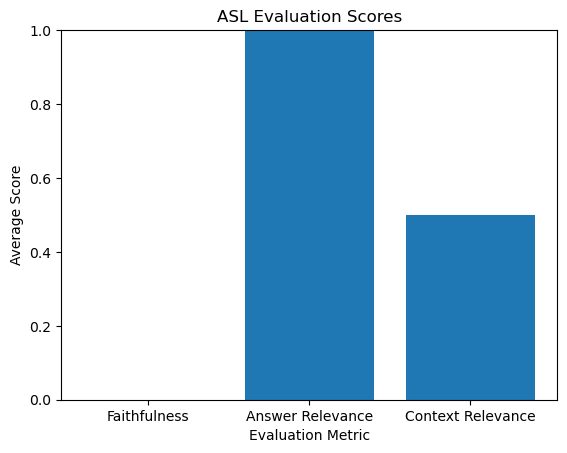

In [23]:
import matplotlib.pyplot as plt

# Plot
labels = ["Faithfulness", "Answer Relevance", "Context Relevance"]
values = [faithfulness_avg, relevance_avg, context_avg]

_, ax = plt.subplots()
ax.bar(labels, values)
ax.set_ylim(0, 1)
ax.set_ylabel("Average Score")
ax.set_xlabel("Evaluation Metric")
ax.set_title("ASL Evaluation Scores")
plt.show()